# Исследование данных о продажах игр
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 

## Описание данных
Name — название игры\
Platform — платформа\
Year_of_Release — год выпуска\
Genre — жанр игры\
NA_sales — продажи в Северной Америке (миллионы проданных копий)\
EU_sales — продажи в Европе (миллионы проданных копий)\
JP_sales — продажи в Японии (миллионы проданных копий)\
Other_sales — продажи в других странах (миллионы проданных копий)\
Critic_Score — оценка критиков (максимум 100)\
User_Score — оценка пользователей (максимум 10)\
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Шаг 1. Знакомство с данными

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [98]:
data = pd.read_csv('/datasets/games.csv')
old_data = data
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating присутсвуют пропуски. У столбцов Year_of_Release и User_Score установлены не верные типы данных. Исправим это на этапе предобработки.

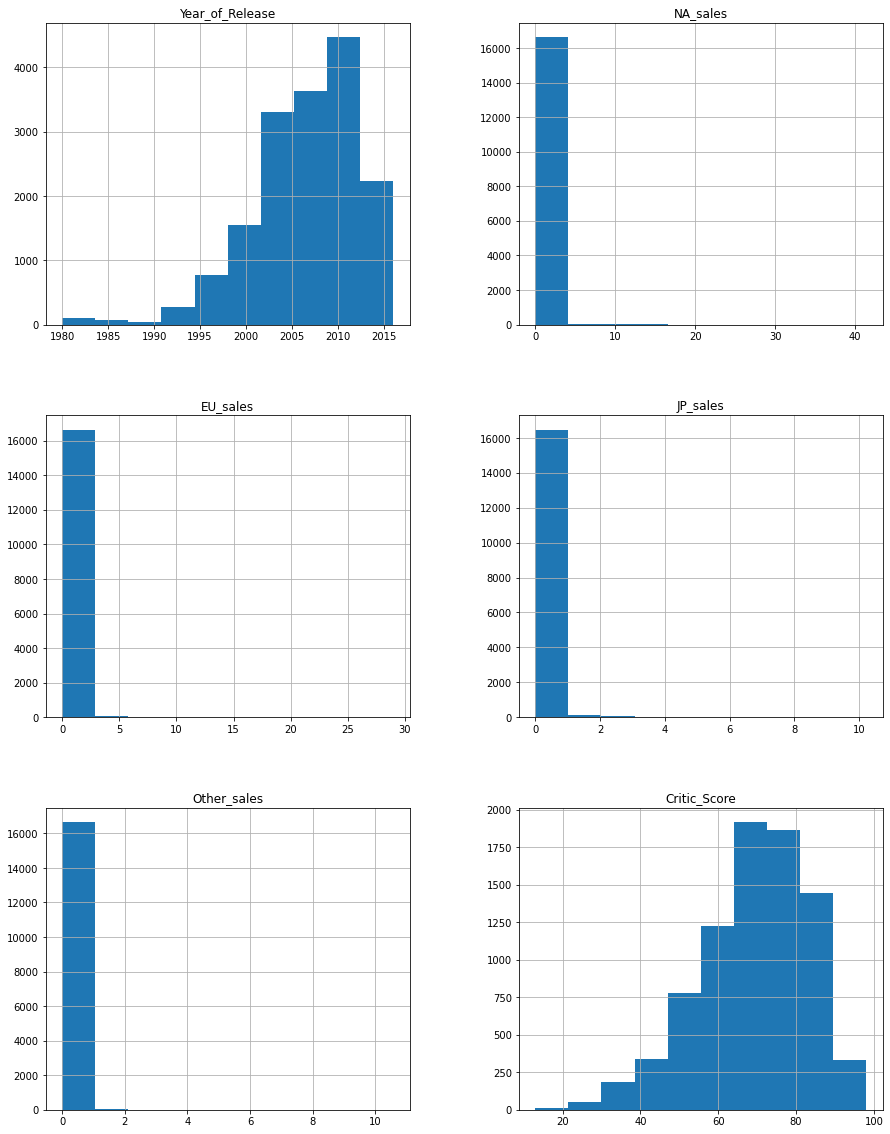

In [100]:
data.hist(figsize=(15, 20));

В столбцах с продажами очевидно присутсвуют выбросы.

In [101]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют

## Шаг 2. Предобработка данных

### Приведение названий столбцов к змеиному регистру

In [102]:
columns = data.columns # вытащим названия столбцов
new_columns = {} # подготовим словарь для новых названий столбцов
for column in columns: # в цикле пройдем по всем столбцам
    new_columns[column] = column.lower() # и добавим в словарь пары старое название - новое название в змеином регистре  
data = data.rename(columns=new_columns) # переименуем столбцы
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Преобразование типов данных

Выполним следующие преобразования:
1. year_of_release приведем к целочисленному типу
2. user_score приведем к вещественному типу

In [103]:
data['year_of_release'].unique() # посмотрим какие значения встречаются столбце year_of_release

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Вещественных чисел нет, но присутсвуют пропуски, которые помешают при замене типа на целочисленный. Так как в дальнейшем необходимо будет рассматривать данные в разрезе по годам, то строки с отсутвующей информацие о годе выпуска будут бесполезны. Избавимся от них.

In [104]:
data.query('year_of_release.isna()').shape[0] / data.shape[0] #посмотрим какой % состовляют пропуски

0.01609332934489979

In [105]:
data = data.query('not year_of_release.isna()')
data['year_of_release'] = data['year_of_release'].astype('int')
data['year_of_release'].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983])

In [106]:
data['user_score'].unique() # посмотрим какие значения встречаются в столбце user_score

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце присутсвуют пропуски, но так как будем преобразовывать в вещественный тип они не должны помешать. А вот значение tbd помешает. Аббревеатура TBD в игровой лексике означает "будет определено", то есть на данный момент не известно, поэтому заменим эти значения на NaN. И изменим тип столбца.

In [107]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)
data['user_score'] = data['user_score'].astype('float')
data['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

### Работа с пропусками

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Пропуски в name, заполнить мы не можем, но так как ключевые показатели платформа и года пропусков не имеют, оставим эти пропуски не тронутыми. Пропуски в столбцах с оценками тоже оставим нетронутыми, так как можем исказить данные. Пропуски в столбах genre и rating зашлушим unknown

In [109]:
data['genre'].fillna('unknown', inplace=True)
data['rating'].fillna('unknown', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int64  
 3   genre            16446 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16446 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


### Добавление нового столбца

Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец total_sales

In [110]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


## Шаг 3. Исследовательский анализ

### 1. Посмотрим, сколько игр выпускалось в разные годы.

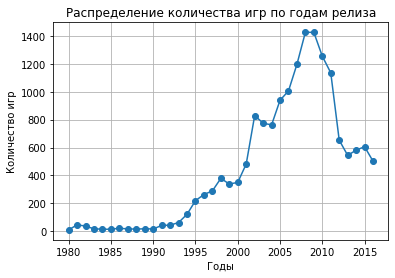

In [111]:
plt.title('Распределение количества игр по годам релиза');
data.groupby('year_of_release')['year_of_release'].count().plot(style='-o', grid=True, xlabel='Годы', ylabel='Количество игр');

С 1980 по 1993 год наблюдается стабильно малое количество выпускаемых игр, индустрия только зарождается, рост числа выпускаемых игр начинается с 1994 вплоть до 2008 - 2009 года, которые являются пиковыми. Спад с 2010 года очевидно связан с мировым кризисом 2008 - 2009 года, во время которого многим игровым компаниям пришлось закрыть часть студий и уволить персонал.

### 2. Посмотрим, как менялись продажи по платформам. 

Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

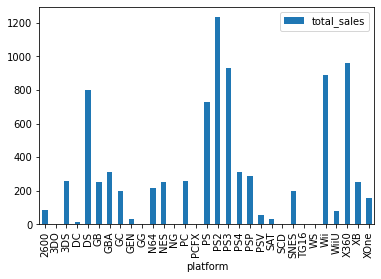

In [112]:
data.pivot_table(index=['platform'], values='total_sales', aggfunc='sum').plot(kind='bar');

Наиболее популярными популярными будем считать 6 платформ c самым большим количеством продаж.

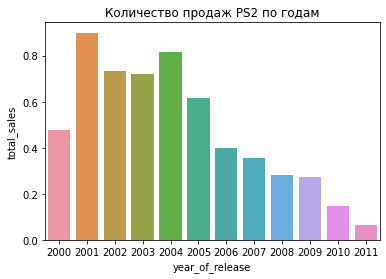

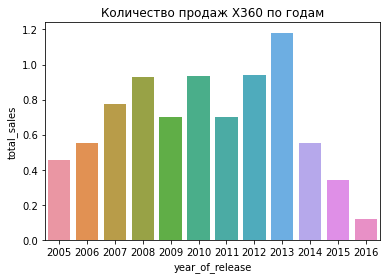

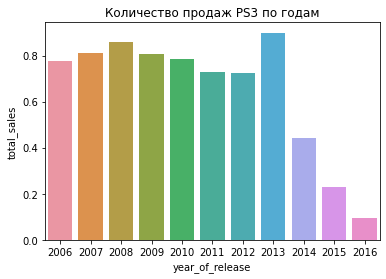

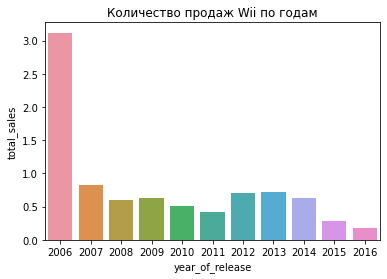

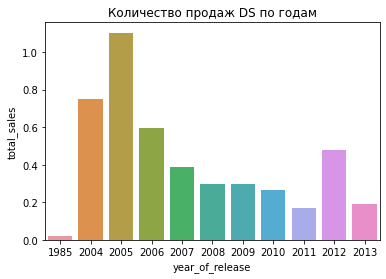

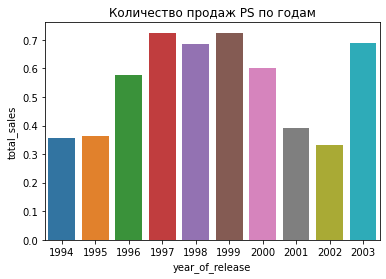

In [113]:
top6 = data.pivot_table(index=['platform'], values='total_sales', aggfunc='sum') \
.sort_values(by='total_sales', ascending=False)[:6]

for platform in top6.index:
    df = data.query('platform == @platform')
    plt.title(f'Количество продаж {platform} по годам')
    sns.barplot(
        data = df,
        x = df['year_of_release'], 
        y = df['total_sales'],
        ci = None
    )
    plt.show()

Судя по графикам можно сделать вывод что средний срок жизни равен 10 годам. При этом среди 6 популярных 3 уже закрылись в 2003, 2011 и 2013 году соответсвенно. 

### 3. Определим актуальный период 

Актуальный период, на мой взгляд, это тот период, при котором живы все компании, на которые мы будем делать прогноз на 2017 год. Из предыдуших пунктов можно заметить, что в 2013 году закончила работу компания DS которая являлась одной из наиболее популярных компаний. Поэтому, актуальный период возьмем с 2014 по 2016. Тем более что в эти годы наблюдается подъем после долгого спада (кризис 2008-2009 года). 

In [114]:
actual_data = data.query('2014 <= year_of_release')

В дальнейшей работе не будем учитывать данные за предыдущие годы.

### 4. Какие платформы лидируют по продажам, растут или падают?

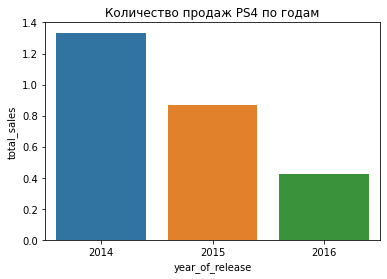

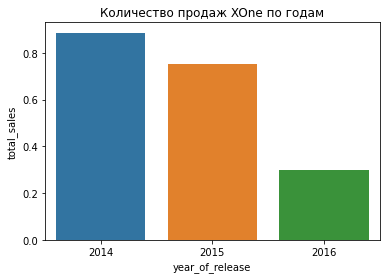

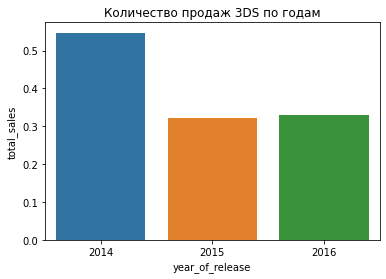

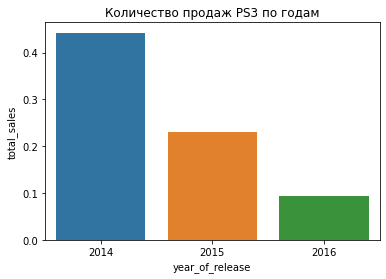

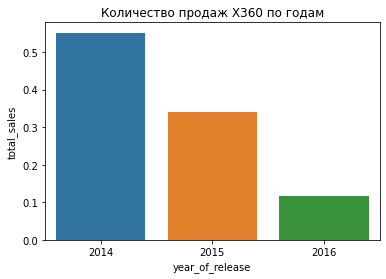

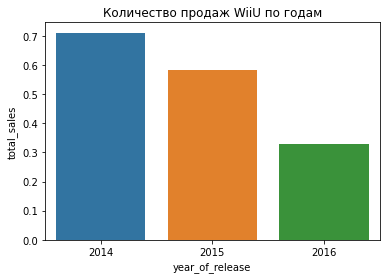

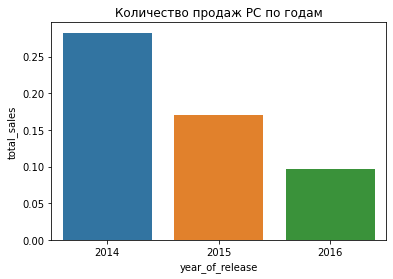

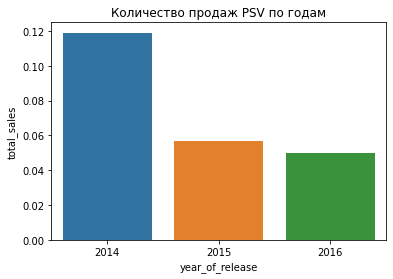

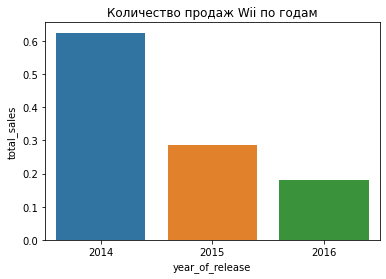

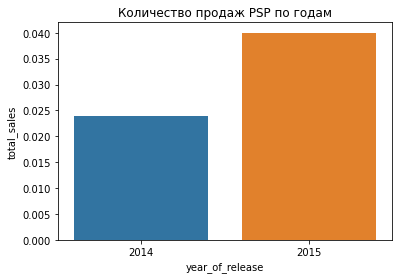

In [115]:
top = actual_data.pivot_table(index=['platform'], values='total_sales', aggfunc='sum') \
.sort_values(by='total_sales', ascending=False)

for platform in top.index:
    df = actual_data.query('platform == @platform')
    plt.title(f'Количество продаж {platform} по годам')
    sns.barplot(
        data = df,
        x = df['year_of_release'], 
        y = df['total_sales'],
        ci = None
    )
    plt.show()

Из дальнейшего рассмотрения можно исключить PSP потому что в 2016 году не было выпущено ни одной игры, что скорее всего говорит о том, что студия закрылась. Из оставшихся потенциально прибыльными можно считать только 3DS, так как там наблюдается незначительный рост продаж с 2015 на 2016 год. На всех остальных платформах наблюдается спад. Но в целом рассуждать о прибыльности платформы сложно не зная стоимость игр и затраты на их производтсво. 

In [116]:
actual_data = actual_data.query('platform != "PSP"')

### 5. Посмтроим "ящик с усами" по глобальным продажам в разбивке по платформам

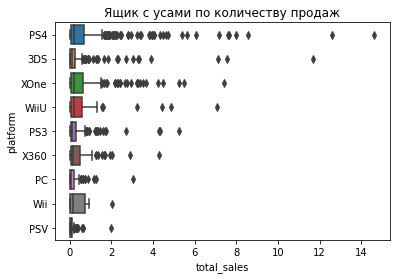

In [117]:
sns.boxplot(data=actual_data, x='total_sales', y='platform');
plt.title('Ящик с усами по количеству продаж');

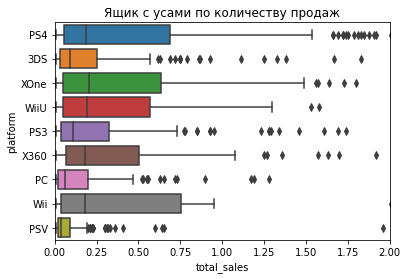

In [118]:
sns.boxplot(data=actual_data, x='total_sales', y='platform');
plt.title('Ящик с усами по количеству продаж');
plt.xlim(0, 2);

Очевидно, что наиболее прибыльной за актульный период является PS4 у нее и самый широкий спектр нормальных значений и игры с самым большим количеством продаж выпускались ей игры выпускались ей (свыше 14млн копий). Xone, WiiU и X360 имеет чуть меньший спектр нормальных значений, и соответсвенно меньший размах выбросов (до 8 млн копий). Приемачательной и на этом графике выглядит 3DS. Размах нормальных значений гораздо меньше, но присутсвуют игры, которые по количеству продаж обходят Xone, WiiU и X360.

### 6. Посмотрим как оценки пользователей и критиков влияют на продажи PS4

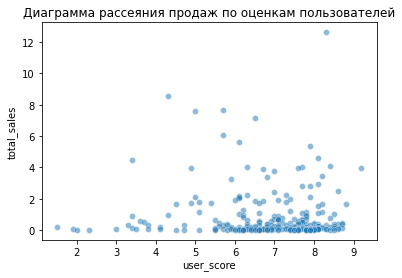

In [119]:
ps4_data = actual_data.query('platform == "PS4"')
sns.scatterplot(data=ps4_data, x='user_score', y='total_sales', alpha=0.5); 
plt.title('Диаграмма рассеяния продаж по оценкам пользователей');

In [120]:
ps4_data['user_score'].corr(ps4_data['total_sales']) # рассчитаем корреляцию

-0.040131589472697356

Оценка пользователй не оказывает никакого влияния на количество продаж

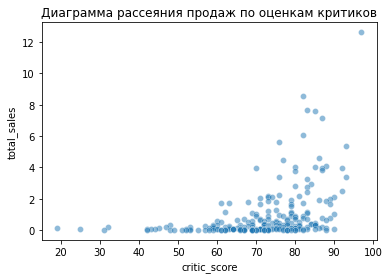

In [121]:
sns.scatterplot(data=ps4_data, x='critic_score', y='total_sales', alpha=0.5);
plt.title('Диаграмма рассеяния продаж по оценкам критиков');

In [122]:
ps4_data['critic_score'].corr(ps4_data['total_sales'])

0.40266141068104083

Наблюдается слабая зависимость количества продаж от оценки критиков.

### 7. Соотнесем выводы с продажами на других платформах

Для этого построим диаграммы рассеяния рассчитаем и корреляцию для других 8 платформ

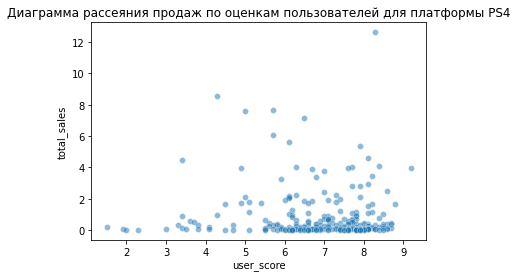

Корреляция продаж и оценок пользователей платформы PS4 -0.040131589472697356



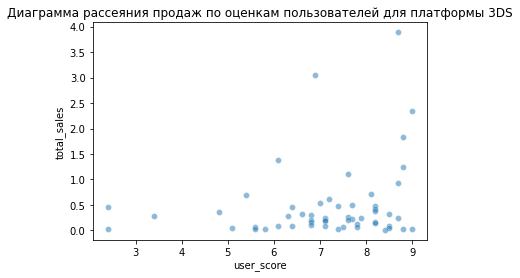

Корреляция продаж и оценок пользователей платформы 3DS 0.2151932718527028



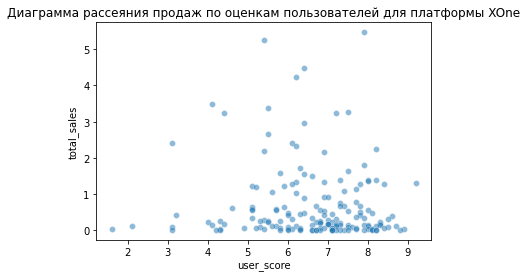

Корреляция продаж и оценок пользователей платформы XOne -0.0703839280647581



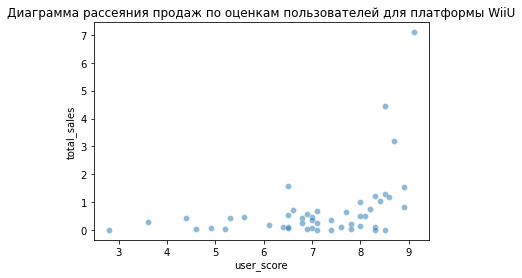

Корреляция продаж и оценок пользователей платформы WiiU 0.40792645792170773



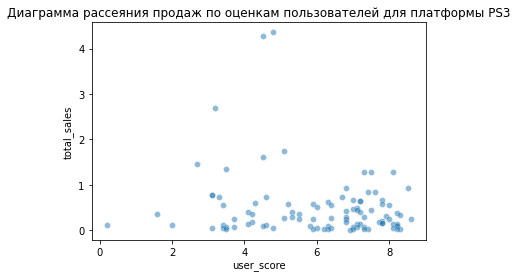

Корреляция продаж и оценок пользователей платформы PS3 -0.16676141347662118



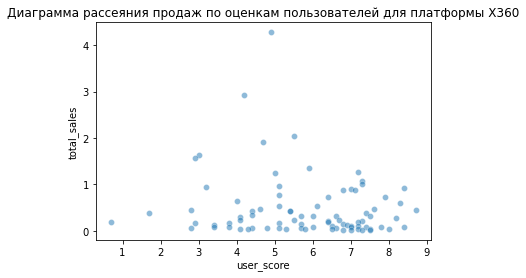

Корреляция продаж и оценок пользователей платформы X360 -0.138444570945665



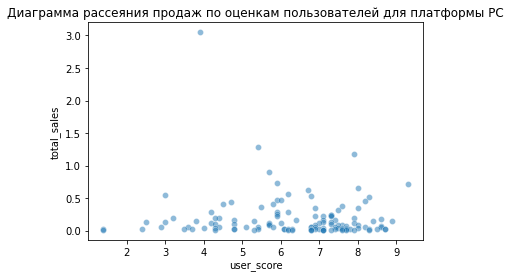

Корреляция продаж и оценок пользователей платформы PC -0.07159665703472451



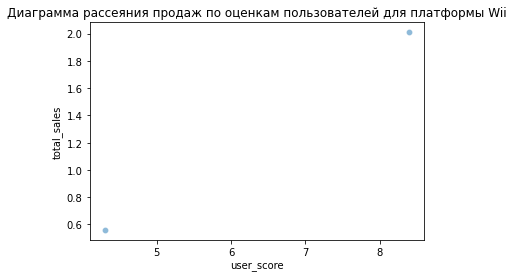

Корреляция продаж и оценок пользователей платформы Wii 1.0



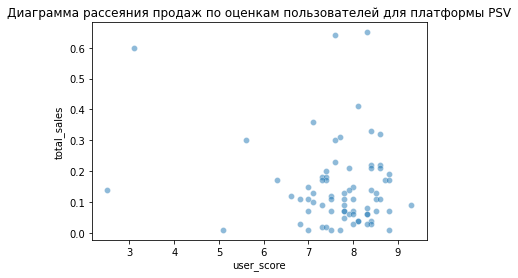

Корреляция продаж и оценок пользователей платформы PSV -0.16845504978064446



In [123]:
actual_platform = actual_data['platform'].unique()
for platform in actual_platform:
    df = actual_data.query('platform == @platform')  
    plt.title(f'Диаграмма рассеяния продаж по оценкам пользователей для платформы {platform}');
    sns.scatterplot(data=df, x='user_score', y='total_sales', alpha=0.5); 
    plt.show()
    print(f'Корреляция продаж и оценок пользователей платформы {platform}', df['user_score'].corr(df['total_sales']))
    print()

На всех платформах примерно одна и та же картина, корреляции между пользовательской оценкой и количеством продаж нет. (1 на Wii обусловлена не достаточностью данных)

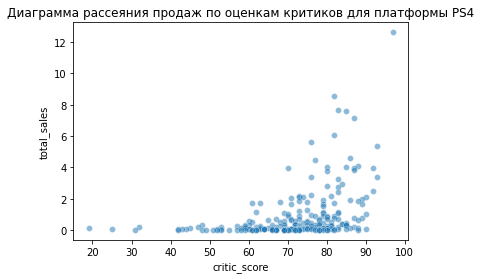

Корреляция продаж и оценок критиков платформы PS4 0.40266141068104083



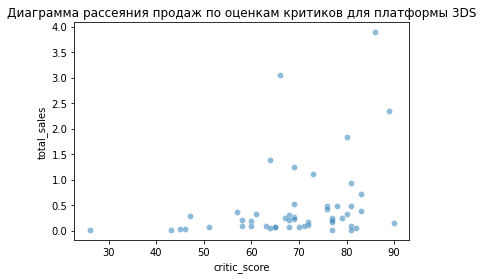

Корреляция продаж и оценок критиков платформы 3DS 0.314117492869051



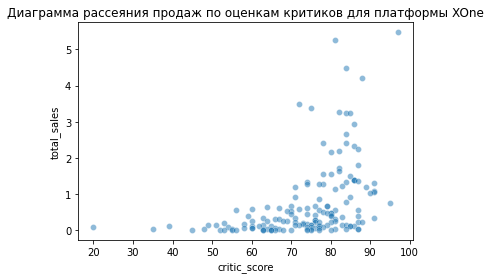

Корреляция продаж и оценок критиков платформы XOne 0.42867694370333226



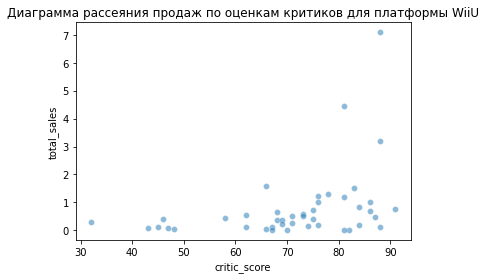

Корреляция продаж и оценок критиков платформы WiiU 0.370201412480884



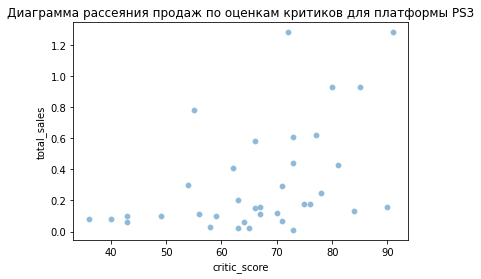

Корреляция продаж и оценок критиков платформы PS3 0.44657460493190704



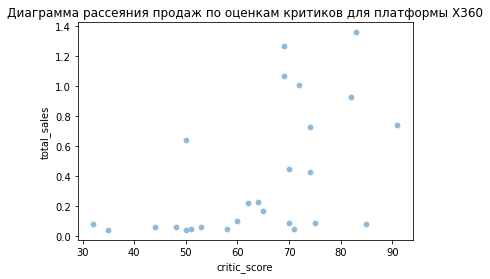

Корреляция продаж и оценок критиков платформы X360 0.5257228356581523



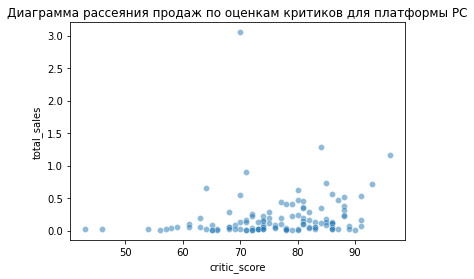

Корреляция продаж и оценок критиков платформы PC 0.17463413769350036



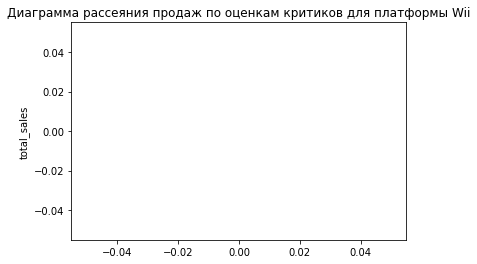

Корреляция продаж и оценок критиков платформы Wii nan



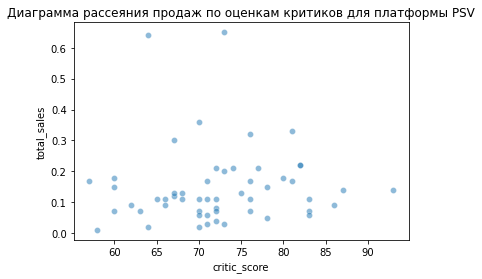

Корреляция продаж и оценок критиков платформы PSV 0.04266490657009526



In [124]:
for platform in actual_platform:
    df = actual_data.query('platform == @platform')  
    plt.title(f'Диаграмма рассеяния продаж по оценкам критиков для платформы {platform}');
    sns.scatterplot(data=df, x='critic_score', y='total_sales', alpha=0.5); 
    plt.show()
    print(f'Корреляция продаж и оценок критиков платформы {platform}', df['critic_score'].corr(df['total_sales']))
    print()

Зависимость оценки критиков и количества продаж либо незначительна, либо вовсе отсутствует.

**Вывод:** оценки пользователей и критиков не влияют на количество продаж.

### 8. Посмотрим на общее распределение игр по жанрам

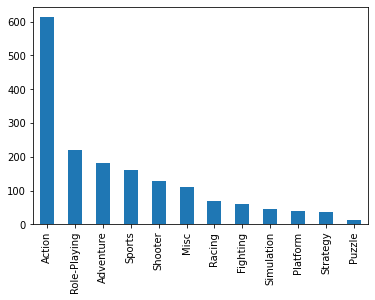

In [125]:
actual_data['genre'].value_counts().plot(kind='bar');

Игр жанра Action выпускается значительно больше всех остальных, это не удивительно так как в данном жанре большее разнообразие тематик. Самыми редкими являются игры puzzle.

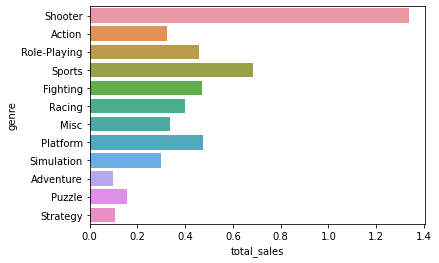

In [126]:
sns.barplot(
    data = actual_data,
    x = 'total_sales',
    y = 'genre',
    ci = None
);

Жанр shooter является абсолютным чемпионом по количеству продаж, в два раза опережая своего предшественника. И это при условии, что по количеству выпускаемых игр они находятся лишь на 5 месте. Реже всего покупают игры жанра adventure. А вот наиболее часто выпускаемые игры жанра action имеют не очень высокие продажи. Вероятно это связано с переизбытком предложения на рынке.

## Шаг 4. Составим портрет пользователя каждого региона

Для этого определим для пользователя каждого региона (NA, EU, JP):
1. Самые популярные платформы (топ-5). 
2. Самые популярные жанры (топ-5). 
3. Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### 1. Самые популярные платформы

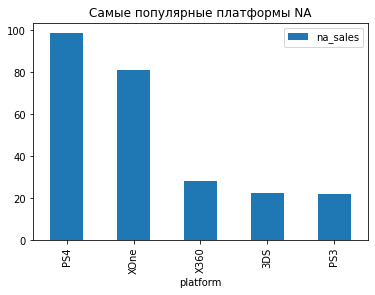

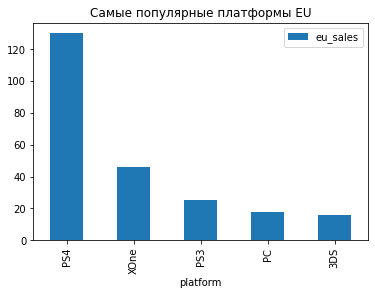

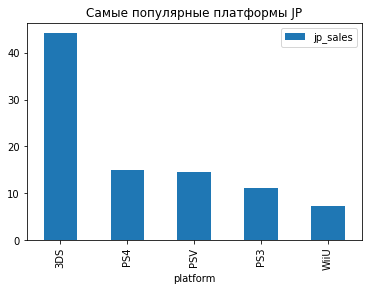

In [127]:
region_sales = ['na_sales', 'eu_sales', 'jp_sales']
for i in region_sales:
    actual_data.pivot_table(index='platform', values=i, aggfunc='sum').sort_values(by=i,ascending=False)[:5].plot(kind='bar');
    plt.title(f'Самые популярные платформы {i[:2].upper()}');

Если для Северной Америки и Европы препочтения в платформах примерно совпадают, то вот в Японии наиболее часто покупаемыми являются игры платформы 3DS, притом доля продаж там в 3 раза выше чем продажы PS4, которая является лидером в Европе и Америке. Это связано с тем что 3DS  является японской платформой.

### 2. Самые популярные жанры

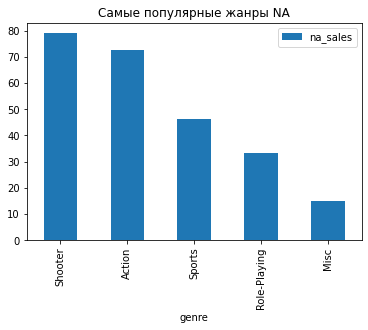

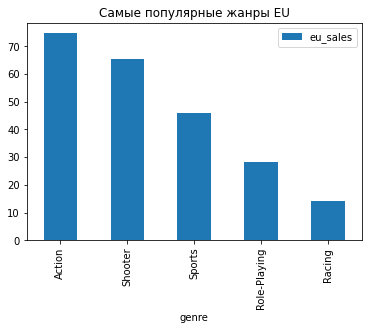

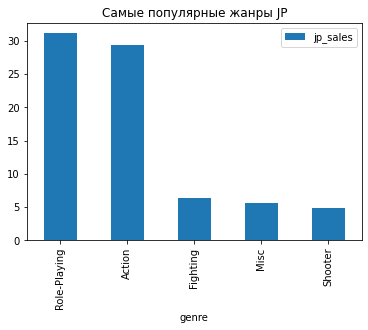

In [128]:
for i in region_sales:
    actual_data.pivot_table(index='genre', values=i, aggfunc='sum').sort_values(by=i,ascending=False)[:5].plot(kind='bar');
    plt.title(f'Самые популярные жанры {i[:2].upper()}');

С жанрами примерно так же ситуация. Если жанр action примерно одинаково популярен во всех трех регионах, то вот про жанр role-playing можно утверждать, что он гораздо популярнее в Японии нежеле на западе.

### 3. Влияет ли рейтинг ESRB на продажи в отдельном регионе?

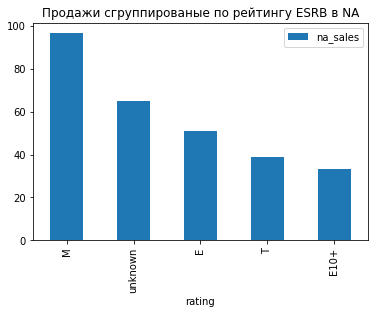

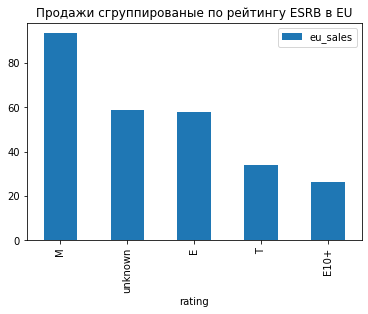

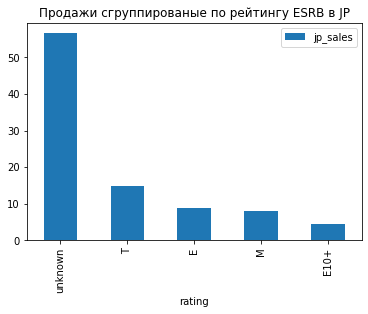

In [129]:
for i in region_sales:
    actual_data.pivot_table(index='rating', values=i, aggfunc='sum').sort_values(by=i,ascending=False)[:5].plot(kind='bar');
    plt.title(f'Продажи сгруппированые по рейтингу ESRB в {i[:2].upper()}');

В Америке и Европе чаще всего продаются игры рейтинга М (для взрослых), на втром месте игры, рейтинг которых не известен, следом E (для всех), T (для подростков) и E10+ (для всех от 10 лет и старше). Если про жанр е10+ можно сказать, что он во всех рех регионах является наименее популярным, то вот популярность жанра T это отличительная черта Японии. Но в целом по Японии для подавляющего большинства игр не известен рейтинг. Скорее всего это связано с тем, что возрастной рейтинг на Западе и в Японии, определяется по разным критериям.

**Вывод:** Портреты пользователей Севреной америки и Европы практически идентичны. А вот портрет пользователя Японии сильно отличается как в предпочтениях жанра и платформы, так и в целом по возрасту пользователя.

### Шаг 5. Проверка гипотез

### 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые


Сформулируем нулевую и альтернативную гипотезы:\
Н0: Средние пользовательские рейтинги платформ Xbox One и PC равны\
Н1: Средние пользовательские рейтинги платформ Xbox One и PC не равны\
Для проверки гипотезы о равенстве средних двух не зависимых ввборок применим метод scipy.stats.ttest_ind (), с параметром equal_var = True, так как есть все основания полагать, что дисперсии у данных величин будут одинаковы (речь идет об оценках от 1 до 10)

In [130]:
xbox_one_user_score = actual_data.query('platform == "XOne"')['user_score'].dropna()
pc_user_score = actual_data.query('platform == "PC"')['user_score'].dropna()

alpha = .01

results = st.ttest_ind(xbox_one_user_score, pc_user_score, equal_var=True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Принимаем альтернативную")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


Не отвергаем гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

### 2. Средние пользовательские рейтинги жанров Action и Sports разные.

Сформулируем нулевую и альтернативную гипотезы:\
Н0: Средние пользовательские рейтинги жанров Action и Sports равны\
Н1: Средние пользовательские рейтинги жанров Action и Sports не равны\
Для проверки гипотезы о равенстве средних двух не зависимых ввборок применим метод scipy.stats.ttest_ind (), с параметром equal_var = True, так как есть все основания полагать, что дисперсии у данных величин будут одинаковы (речь идет об оценках от 1 до 10)

In [131]:
action_user_score = actual_data.query('genre == "Action"')['user_score'].dropna()
sports_user_score = actual_data.query('genre == "Sports"')['user_score'].dropna()

alpha = .01

results = st.ttest_ind(action_user_score, sports_user_score, equal_var=True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Принимаем альтернативную")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу. Принимаем альтернативную


Принимаем гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные.

## Шаг 6. Общий вывод

В процессе работы над проектом были осуществлены:
1. Предобработка данных
    1.1 Преведение названий столбцов к змеиному регистру 
    1.2 Преобразование типов данных в столбцах year_of_release и user_score
    1.3 Обработка пропусков
    1.4 Добавление нового столбца с количеством общих продаж total_sales
2. Исследовательский анализ данных, в ходе которого установлено:
    2.1 Пиковые значения количества выпускаемых игр приходятся на 2008-2009 год, за которым следует долгий крутой спад, свидетельствующий о последствиях мирового экономического кризиса 2008 года, отразившегося так же и на игровой индустрии
    2.2 Платформами с наибольшим количеством продаж за все время являются PS2, X360, PS6, Wii, DS, PC
    2.3 Актуальным периодом для прогноза на 2017 год был принят период с 2014 - 2016 год, так как делать прогноз на следующий год целесообразно делать, только с учетом действующих компаний. В дальнейшем анализе рассматривались данные только за актуальный период.
    2.4 В акутальный период наблюдается стабильный спад по количеству продаж игр всеми платформами, кроме DS
    2.5 Не смотря, что в среднем большее количество продаж аблюдается на платформах PS4 и Xone, платформой DS выпускаются некоторые бестселлеры, которые обгоняют по количеству продаж PS4 и Xone
    2.6 Оценки пользователей и критиков не оказывают влияния на количество продаж.
    2.7 Игр жанра action производится гораздо больше остальных, но самым успешным по продажам является жанр shooter
3. Составление портрета пользователя каждого региона
    3.1 Пользователи Северной Америки и Европы очень похожи в своих предпочтениях. В отличие от пользователей Японии.
    3.2 Самые популярная платформа среди западных пользователей PS4, среди японских DS
    3.3 Самы популярные жанры среди американских пользователей shooter, европейских - action, японских - role-plaing
    3.4 Распеределение продаж по рейтингу у западных пользователей одинковое, лидирует рейтинг М - для взрослых. В Японии лидирует рейтинг T - для подростков.
4. Проверка гипотез
    4.1 Гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, отвергнуть не получилось, а значит необходимы дополнительные исследования
    4.2 Гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports разные принята
    
**Вывод:** Для проведения успешной кампании в 2017 году необходимо сперва определится с рынком, для которого будет производится продукция.\
Если для западных пользователей то, стоит сделать акцент на производство игр жанра Shooter так как продажи по ним в Америке на первом месте, в Европе - на втором. При этом по количеству выпускаемых игр жанр shooter находится только на 5 месте, что говорит о меньшей конкуренции, а значит более высокой цене. В отличие от жанра action, который может и находится на первом месте по продажам в Европе, но предложение таких игр в 5 раз превышает предложение игр жанра shooter. \
Если ставка делается на японских пользователей, то стоит сделать акцент на производство игр жанра role-plaing и учитывать, что возрастной рейтинг должен быть T - для подростков.